In [1]:
from xfoil import XFoil
from xfoil.model import Airfoil
from xfoil.test import naca0012

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from scipy import interpolate

from config import *
from modules import *

In [ ]:
run_foils = 150

# get list of alfas and alfa step
alfa_step, alfas = get_alfa_step(alfa_min, alfa_max, n_points_alfa)

# set list of Re's
Re = np.linspace(re_min, re_max, n_points_Re).astype(int)

print("Alfas:", alfas)
print("Re's:", Re)

foils_counter = 0

for fname in os.listdir(foils_dat_path):
    
    foils_counter += 1
    
    # check whether the foil analyzed already
    if fname.replace(".dat", ".pkl") in os.listdir(foils_pkl_path):
        print(foils_counter, 'Work on', fname, "     --> Foil's pkl file already exists, skipping.")
        continue
    else:
        print(foils_counter, 'Work on', fname)
    
    # set up result dictionary
    foil_output = {}
    
    # set up foil data array
    foil_array = np.zeros((n_foil_params, n_points_Re, n_points_alfa))
    pre_foil_array = np.zeros((n_foil_params, n_points_Re, n_points_alfa))
        
    # load foil coords from file
    try:
        x, y = read_airfoil_dat_file(Path(foils_dat_path, fname))
    except:
        print("W: Foil %s failed to read from file, skipped." % (fname))
        continue
    
    # keep in output dict
    foil_output['x_raw'] = x
    foil_output['y_raw'] = y
    
    # convert coords to n_foil_points
    try:
        x, y = interpolate_airfoil(x, y, n_foil_points)
    except:
        print("W: Foil %s failed to interpolate to %i points, skipped." % (fname, n_foil_points))
        continue
    
    # set an Airfoil object on these coords
    current_foil = Airfoil(x,y)
    
    # get root and flap thicknesses 
    try:
        d = get_foil_flap_thickness(current_foil)
        S = get_foil_root_thickness(current_foil) 
    except:
        print("W: Foil %s failed to get thicknesses, skipped." % (fname))
        continue     

    # store in ary
    foil_array[4, :, :] = d
    foil_array[5, :, :] = S    

    # setup xfoil lib
    xf = XFoil()
    xf.airfoil = current_foil
    xf.max_iter = xfoil_max_iterations

    # xfoiling for each Re
    for num in range(16):
        
        xf.Re = Re[num]        
        a, cl, cd, cm, cp = xf.aseq(alfa_min, alfa_max, alfa_step)  
        
        assert (len(a)==n_points_alfa), "Lenght of alfa array is wrong!"
        
        nans_percent = sum(np.isnan(a))/len(a)
        
        # interpolate gaps in alfa plane
        if nans_percent < max_nans_in_curve:            
            cl = fill_gaps_in_xfoil_curve(cl)
            cd = fill_gaps_in_xfoil_curve(cd)
            cm = fill_gaps_in_xfoil_curve(cm)
            cp = fill_gaps_in_xfoil_curve(cp)
        
        # write results to main array
        foil_array[0, num, :] = cl
        foil_array[1, num, :] = cd
        foil_array[2, num, :] = cm
        foil_array[3, num, :] = cp
        foil_array[6, num, :] = Re[num]
        foil_array[7, num, :] = alfas
        
        # write results to debug array
        pre_foil_array[0, num, :] = cl
        pre_foil_array[1, num, :] = cd
        pre_foil_array[2, num, :] = cm
        pre_foil_array[3, num, :] = cp
        pre_foil_array[6, num, :] = Re[num]
        pre_foil_array[7, num, :] = alfas
       
        # interpolate gaps in Re plane
        for alfa in range(32):
            foil_array[0, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[0, :, alfa])
            foil_array[1, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[1, :, alfa])
            foil_array[2, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[2, :, alfa])
            foil_array[3, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[3, :, alfa])            
            
    # save or discard data
    if np.sum(np.isnan(foil_array))==0:
        
        # fill output dict
        foil_output['X'] = foil_array
        foil_output['X_raw'] = pre_foil_array
        foil_output['y'] = current_foil
        foil_output['d'] = d
        foil_output['S'] = S
        
        # save file
        pkl_name = fname.replace(".dat", ".pkl")
        save_pkl(foil_output, Path(foils_pkl_path, pkl_name))        
        print("     --> %i NaNs corrected, file %s saved." % (int(np.sum(np.isnan(pre_foil_array))), pkl_name))
        
    else:
        
        print("W: Foil skipped - %i NaNs in foil_array." % int(np.sum(np.isnan(foil_array))))
        
        

    if foils_counter > run_foils: raise Exception("Required number of processed foils exceeded:", run_foils)        

Alfas: [-2.0999999  -1.78437495 -1.46874988 -1.15312481 -0.83749986 -0.52187485
 -0.20624983  0.10937518  0.42500019  0.7406252   1.05625021  1.37187529
  1.68750024  2.00312519  2.31875014  2.63437533  2.95000029  3.26562524
  3.58125043  3.89687538  4.2125001   4.52812529  4.84375048  5.15937519
  5.47500038  5.79062557  6.10625029  6.42187548  6.73750019  7.05312538
  7.36875057  7.68437529]
Re's: [ 40000  50666  61333  72000  82666  93333 104000 114666 125333 136000
 146666 157333 168000 178666 189333 200000]
1 Work on 2032c.dat
     --> 476 NaNs corrected, file 2032c.pkl saved.
2 Work on a18.dat
     --> 0 NaNs corrected, file a18.pkl saved.
3 Work on a18sm.dat
     --> 128 NaNs corrected, file a18sm.pkl saved.
4 Work on a63a108c.dat
     --> 0 NaNs corrected, file a63a108c.pkl saved.
5 Work on ag03.dat
     --> 0 NaNs corrected, file ag03.pkl saved.
6 Work on ag04.dat
     --> 0 NaNs corrected, file ag04.pkl saved.
7 Work on ag08.dat
     --> 0 NaNs corrected, file ag08.pkl saved

Foil name: ['e342.pkl'] 
Root thickness: 0.14, flap thickness: 0.09
Show curve: Cm


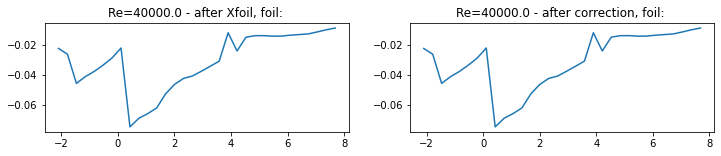

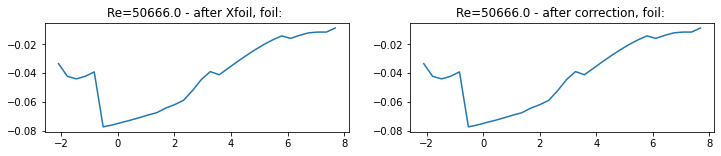

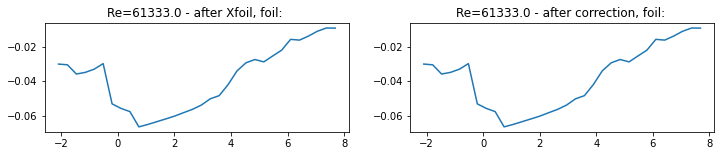

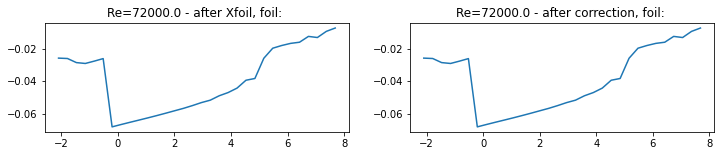

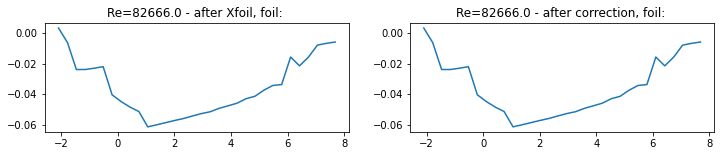

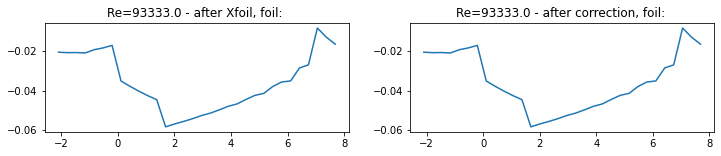

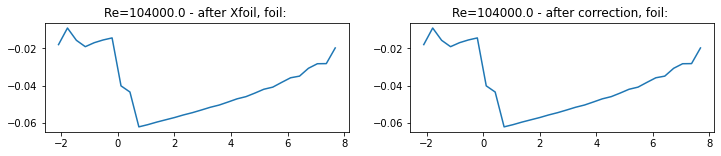

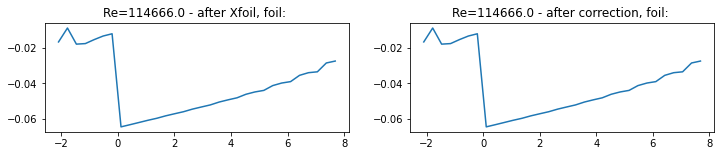

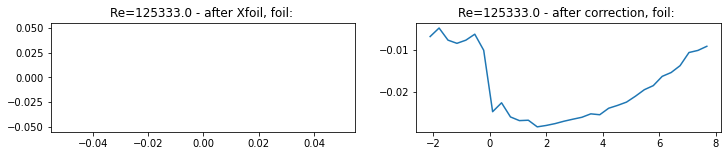

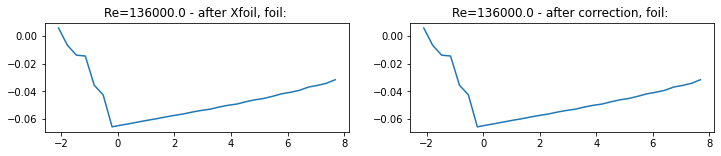

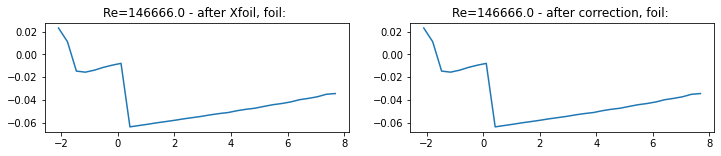

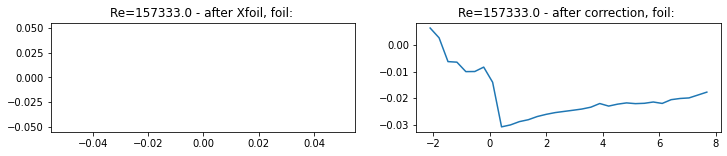

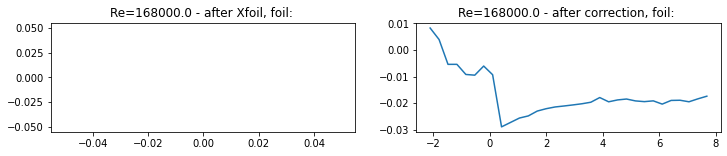

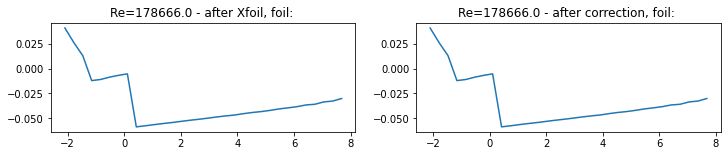

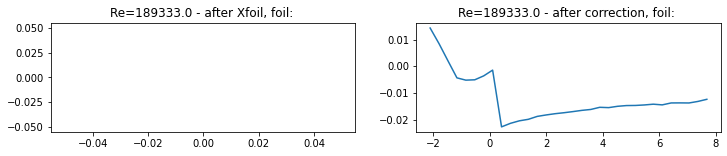

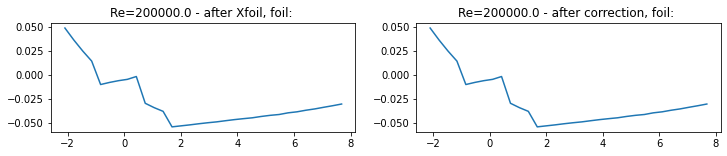

In [3]:
show_foil_info(Path(foils_pkl_path, "e342.pkl"), 'Cm')